In [3]:
import cv2 as cv
import numpy as np
from skimage.feature import peak_local_max
from matplotlib import pyplot as plt

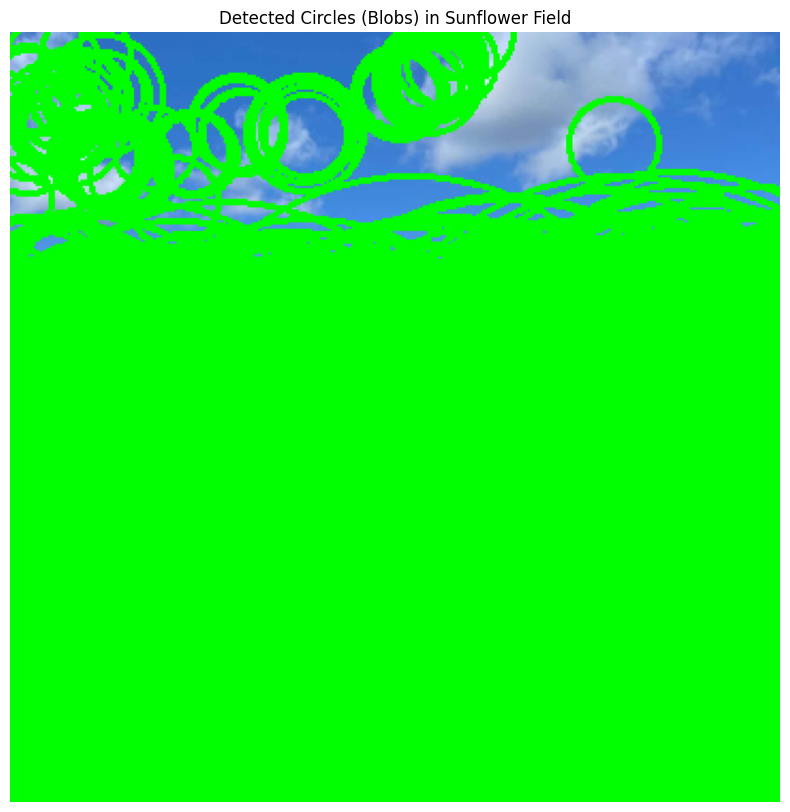

Sigma values range used: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


In [4]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

def laplacian_of_gaussian(img, sigma):
    """Apply Gaussian blur followed by Laplacian."""
    blur = cv.GaussianBlur(img, (0, 0), sigma)
    log = cv.Laplacian(blur, cv.CV_64F)
    return log

def detect_blobs(img, num_scales=10, sigma_start=1.0, sigma_end=10.0):
    """Detect blobs in the image using Laplacian of Gaussian over scale space."""
    # Convert to grayscale
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    
    # Create scale-space
    sigma_values = np.linspace(sigma_start, sigma_end, num_scales)
    blobs = np.zeros_like(gray, dtype=np.float64)
    
    # Apply LoG across multiple scales
    for sigma in sigma_values:
        log = laplacian_of_gaussian(gray, sigma)
        log = np.square(log)  # Square the Laplacian response
        blobs = np.maximum(blobs, log)  # Keep the maximum response over scales
    
    return blobs, sigma_values

def draw_blobs(img, blobs, threshold=0.02):
    """Draw circles around blobs on the image."""
    img_copy = img.copy()
    # Threshold the blobs
    max_blob_val = np.max(blobs)
    threshold_val = threshold * max_blob_val
    keypoints = np.argwhere(blobs > threshold_val)
    
    # Draw circles around detected blobs
    for y, x in keypoints:
        radius = int(np.sqrt(blobs[y, x]) * 1.5)  # Estimate radius from response
        cv.circle(img_copy, (x, y), radius, (0, 255, 0), 2)
    
    return img_copy

# Load the sunflower field image
img = cv.imread('images/the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)

# Detect blobs in the image
blobs, sigma_values = detect_blobs(img)

# Draw the detected blobs (approximated as circles)
blob_image = draw_blobs(img, blobs)

# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(cv.cvtColor(blob_image, cv.COLOR_BGR2RGB))
plt.title("Detected Circles (Blobs) in Sunflower Field")
plt.axis("off")
plt.show()

# Report the range of sigma values used
print(f"Sigma values range used: {sigma_values}")

# Optionally, you can also report the largest blobs or additional details here.


In [18]:
import cv2
from pylab import *
import numpy as np
import matplotlib.pyplot as plt
img = cv2.imread("images\\the_berry_farms_sunflower_field.jpeg",0) #gray scale conversion
from scipy import ndimage
from scipy.ndimage import filters
from scipy import spatial
k = 1.414
sigma = 1.0
img = img/255.0  #image normalization

In [16]:
def LoG(sigma):
    #window size 
    n = np.ceil(sigma*6)
    y,x = np.ogrid[-n//2:n//2+1,-n//2:n//2+1]
    y_filter = np.exp(-(y*y/(2.*sigma*sigma)))
    x_filter = np.exp(-(x*x/(2.*sigma*sigma)))
    final_filter = (-(2*sigma**2) + (x*x + y*y) ) *  (x_filter*y_filter) * (1/(2*np.pi*sigma**4))
    return final_filter

In [19]:
def LoG_convolve(img):
    log_images = [] #to store responses
    for i in range(0,9):
        y = np.power(k,i) 
        sigma_1 = sigma*y #sigma 
        filter_log = LoG(sigma_1) #filter generation
        image = cv2.filter2D(img,-1,filter_log) # convolving image
        image = np.pad(image,((1,1),(1,1)),'constant') #padding 
        image = np.square(image) # squaring the response
        log_images.append(image)
    log_image_np = np.array([i for i in log_images]) # storing the #in numpy array
    return log_image_np
log_image_np = LoG_convolve(img)
print(log_image_np.shape)

(9, 1442, 1442)


In [10]:
def detect_blob(log_image_np):
    co_ordinates = [] #to store co ordinates
    (h,w) = img.shape
    for i in range(1,h):
        for j in range(1,w):
            slice_img = log_image_np[:,i-1:i+2,j-1:j+2] #9*3*3 slice
            result = np.amax(slice_img) #finding maximum
            if result >= 0.05: #threshold
                z,x,y = np.unravel_index(slice_img.argmax(),slice_img.shape)
                co_ordinates.append((i+x-1,j+y-1,k**z*sigma)) #finding co-rdinates
    return co_ordinates
co_ordinates = list(set(detect_blob(log_image_np)))

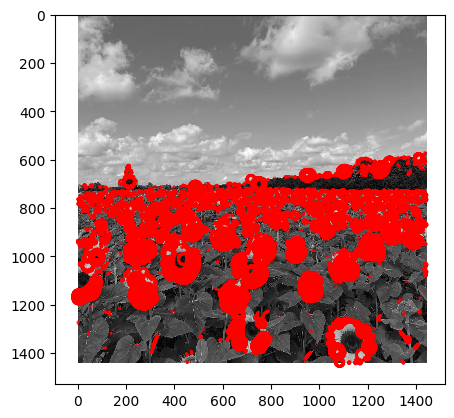

In [11]:
fig, ax = plt.subplots()
nh,nw = img.shape
count = 0


ax.imshow(img, interpolation='nearest',cmap="gray")
for blob in co_ordinates:
    y,x,r = blob
    c = plt.Circle((x, y), r*1.414, color='red', linewidth=1.5, fill=False)
    ax.add_patch(c)
ax.plot()  
plt.show()

In [ ]:
import math

#provided in scipy doucumentaion
def blob_overlap(blob1, blob2):
    n_dim = len(blob1) - 1
    root_ndim = sqrt(n_dim)
    #print(n_dim)
    
    # radius of two blobs
    r1 = blob1[-1] * root_ndim
    r2 = blob2[-1] * root_ndim
    
    d = sqrt(np.sum((blob1[:-1] - blob2[:-1])**2))
    
    #no overlap between two blobs
    if d > r1 + r2:
        return 0
    # one blob is inside the other, the smaller blob must die
    elif d <= abs(r1 - r2):
        return 1
    else:
        #computing the area of overlap between blobs
        ratio1 = (d ** 2 + r1 ** 2 - r2 ** 2) / (2 * d * r1)
        ratio1 = np.clip(ratio1, -1, 1)
        acos1 = math.acos(ratio1)

        ratio2 = (d ** 2 + r2 ** 2 - r1 ** 2) / (2 * d * r2)
        ratio2 = np.clip(ratio2, -1, 1)
        acos2 = math.acos(ratio2)

        a = -d + r2 + r1
        b = d - r2 + r1
        c = d + r2 - r1
        d = d + r2 + r1

        area = (r1 ** 2 * acos1 + r2 ** 2 * acos2 -0.5 * sqrt(abs(a * b * c * d)))
        return area/(math.pi * (min(r1, r2) ** 2))
    
def redundancy(blobs_array, overlap):
    sigma = blobs_array[:, -1].max()
    distance = 2 * sigma * sqrt(blobs_array.shape[1] - 1)
    tree = spatial.cKDTree(blobs_array[:, :-1])
    pairs = np.array(list(tree.query_pairs(distance)))
    if len(pairs) == 0:
        return blobs_array
    else:
        for (i, j) in pairs:
            blob1, blob2 = blobs_array[i], blobs_array[j]
            if blob_overlap(blob1, blob2) > overlap:
                if blob1[-1] > blob2[-1]:
                    blob2[-1] = 0
                else:
                    blob1[-1] = 0
        return np.array([b for b in blobs_array if b[-1] > 0])
                
co_ordinates = np.array(co_ordinates)
co_ordinates = redundancy(co_ordinates,0.5)

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image (reduced color for performance)
img = cv2.imread('images/the_berry_farms_sunflower_field.jpeg', cv2.IMREAD_REDUCED_COLOR_4)
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray_img = gray_img / 255.0  # Normalize the image

# Parameters
k = 1.414  # Scale multiplier
initial_sigma = 1.0  # Initial sigma value
num_scales = 30  # Number of scales to apply

# Blob detection using Laplacian of Gaussian at multiple scales
def detect_blobs(gray_img, num_scales, initial_sigma, k):
    h, w = gray_img.shape
    log_images = []
    sigma_values = []
    
    for i in range(num_scales):
        sigma = initial_sigma * (k ** i)
        # Apply Gaussian blur with current sigma
        blurred_img = cv2.GaussianBlur(gray_img, (0, 0), sigma)
        # Apply Laplacian to the blurred image
        log_img = cv2.Laplacian(blurred_img, cv2.CV_64F)
        # Square the result to emphasize the blobs
        log_img = np.square(log_img)
        log_images.append(log_img)
        sigma_values.append(sigma)

    log_images = np.array(log_images)
    
    return log_images, sigma_values

# Detect local maxima in scale-space
def find_blobs(log_images, threshold=0.05, initial_sigma=1.0, k=1.6):
    blobs = []
    num_scales, h, w = log_images.shape
    
    for i in range(1, h-1):
        for j in range(1, w-1):
            for scale in range(1, num_scales-1):
                # Look for local maxima across scales and spatial neighborhoods
                slice_img = log_images[scale-1:scale+2, i-1:i+2, j-1:j+2]
                max_value = np.max(slice_img)
                if max_value >= threshold:
                    # Find the coordinates of the blob
                    z, x, y = np.unravel_index(slice_img.argmax(), slice_img.shape)
                    # Correct the coordinates and calculate the radius
                    blobs.append((i + x - 1, j + y - 1, initial_sigma * (k ** (scale-1))))
    
    return blobs

# Run the detection
log_images, sigma_values = detect_blobs(gray_img, num_scales, initial_sigma, k)
blobs = find_blobs(log_images, initial_sigma=initial_sigma, k=k)

# Remove duplicates by rounding coordinates
blobs = list(set([(int(x), int(y), r) for x, y, r in blobs]))

# Report the largest blob
largest_blob = max(blobs, key=lambda x: x[2])
print(f"Largest Blob Coordinates: (x={largest_blob[1]}, y={largest_blob[0]}) with radius={largest_blob[2]}")

# Plotting the results
fig, ax = plt.subplots()
ax.imshow(gray_img, cmap='gray')

for blob in blobs:
    y, x, r = blob
    circle = plt.Circle((x, y), r * np.sqrt(2), color='red', linewidth=1.5, fill=False)
    ax.add_patch(circle)

plt.show()

# Print the range of sigma values used
print(f"Range of sigma values used: {min(sigma_values)} to {max(sigma_values)}")
